** optimization inputs:** 
1. coding sequence (target + linker + essential), nucleotides alphabet. make sure that the target and essential are divisible by three. 
2. optimization parameter: tAI, NTE, TDR or codon usage fraction (consider adding CAI). 
3. optimization method: `use_best_codon`, `match_codon_usage`, or `harmonize_rca`
4. GC content - give a range (minimum and maximum). window size is default.  
5. restriction enzyme pattern to avoid (from the list of `rest_dict.keys()` from rest_dict in bioPython)
6. linker indices - for the extraction of target gene, essential gene and linker.  
7. output path - to save the report. 
8. number of optimized EFM sites

**NOTE:** another input for the funtion is the linker indices as a tuple. It in not provided by the user but by us. 

**output: optimized sequence based on the following steps:** 
1. optimization of initiation of translation - reduce the mRNA folding energy in the start of the sequence (about 15 codons). 
2. optimization of the translation efficiency - combine low GC content with fast codons - report included (**genbank and pdf formats)**.  
3. Unsupervised optimization of stability - EFM optimizer 

**Required packages:**  
* Vienna-RNA (https://www.tbi.univie.ac.at/RNA/download/sourcecode/2_4_x/ViennaRNA-2.4.14.tar.gz) 
* forgi (pip install)
* dnachisel (pip install)
* biopython (pip install)
* sequenticon (pip install)

In [1]:
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from os import chdir
from dnachisel import * # a library for optimizing DNA sequences with respect to a set of constraints and optimization objectives. see https://github.com/Edinburgh-Genome-Foundry/DNAChisel
from dnachisel import reports #to create a pdf report and anotated genebank file
from Bio.Restriction.Restriction_Dictionary import rest_dict ## a list of restriction enzymes and their sequence! 
from dnachisel.Specification.SpecEvaluation import SpecEvaluation
from dnachisel.biotools import group_nearby_indices 
import matplotlib.pyplot as plt
import forgi.visual.mplotlib as fvm
from forgi import load_rna
import zipfile
from os import remove 
from sequenticon import sequenticon
## for EFM
from sklearn.feature_extraction.text import CountVectorizer
import re
from textwrap import wrap
from pathlib import Path
from os.path import join, sep

In [2]:
## import vienna:
vienna_path = '/home/karinsio/my_project_dir/iGEM/Optimization of translation/ViennaRNA-2.4.14/interfaces/Python3/'
import sys
sys.path.append(vienna_path)
import RNA 

### EFM functions:

In [3]:
def modify_df_slippage(df_slippage):
    """Helper function.
    The input is a dataframe containing all the identified slippage areas.
    The function converts each row with N = num_base_units to N-1 rows of the base units to be avoided.
    If the length of the base unit is 1, the output dataframe will only include half of the base units (with "jumps")
    This way, each basic unit will be treated as a constraint in the optimization function,
    since we want to avoid most of the repetitions.

    Example: In an input df_slippage, one of the rows indicates that the sequence "TGTGTGTG" includes a base unit
    of length L=3 with N=4 repetitions.
         start     stop     sequence   length_base_unit  num_base_units
    __________________________________________________________________
    0    395        403     TGTGTGTG         2                 4

    So the output dataframe of the current function will convert this row to N-1=three rows:
       start stop sequence
    __________________
    0  395    397  TG
    1  397    399  TG
    2  399    401  TG
    such that each row contains a basic unit and its indices.
    """
    df = pd.DataFrame(columns=('start', 'end', 'sequence'))

    for j in range(0, len(df_slippage)):  # rows of df_slippage
        NBU = df_slippage.iloc[j].num_base_units
        L = df_slippage.iloc[j].length_base_unit
        if L == 1:
            step = 2
        else:
            step = 1
        for i in range(0, NBU - 1, step):
            df = df.append({'sequence': df_slippage.iloc[j].sequence[int(i * L):int(i * L + L)],
                            'start': int(df_slippage.iloc[j].start + i * L),
                            'end': int(df_slippage.iloc[j].start + i * L + L)},
                           ignore_index=True)
    return df

def convert_df_to_constraints(df_fixed):
    """Helper function.
    The input df has 3 columns: {start, end, and sequence}.
    The "sequence" is a pattern, and the "start" and "end" specify the location of this pattern.
    First, the function creates from this df a dictionary that maps each pattern constraint to its location
    (and convert the location to a tuple).
    The result is in following form: patterns = {"TTT":(292,292+7),"CTGCTGCTG":(673,673+9)}.
    Then, the function converts the patterns into a constraints, to be used an input to the DNAChisel problem.
    """
    patterns = df_fixed.set_index('sequence')[['start', 'end']].T.apply(tuple)
    pattern_constraints = [AvoidPattern(patterns.keys()[k],location=patterns.values[k]) for k in range(0,len(patterns.keys()))]
    return pattern_constraints

### calculate part of sequence based on start and end indexes
def genome_cutter(start, end, seq):
    return seq[start:end]

def find_recombination_sites(example_seq, num_sites):

    ### count all sequences of length 16
    vectorizer = CountVectorizer(analyzer= 'char_wb', ngram_range=(16, 16))
    counter = vectorizer.fit_transform([example_seq]).toarray()

    ### find those that appear more than once
    sites_recombination = list(np.where(counter > 1)[1])

    if len(sites_recombination)==0:
        return pd.DataFrame(columns = ['start_1', 'end_1', 'sequence', 'start_2', 'end_2', 'location_delta', 'site_length', 'log10_prob_recombination_ecoli', 'sequence_number'])

    ### get all sequences
    all_sites = vectorizer.get_feature_names()


    suspect_recombination = []

    for site in sites_recombination:
        ### get current site
        curr_seq = all_sites[site]
        ### get list of locations that are a match to the site
        list_regions = list(re.finditer(curr_seq.upper(), example_seq))
        ### extract coordinates from Match object
        list_regions = [x.span() for x in list_regions]

        suspect_recombination.extend(list_regions)

    ### this is now a list of tuples, containing coordinates of suspect recombination sites
    suspect_recombination = sorted(suspect_recombination)

    ### turn the tuples into a dataframe of start and end coordinates of the sites
    df_recombination = pd.DataFrame(suspect_recombination, columns = ['start', 'end'])

    ### when we have matches larger than 16, they will turn into subsequent matches of 16. The following script is meant
    ### to join them together back to one larger region

    ### find the difference between current start and previous start, and between next end to current end. For ranges in
    ### the middle of a larger region, these will be 1 and 1. For our larger region, we only need the edges, so we get rid
    ### of the rest.
    df_recombination.loc[:, 'start_delta'] = df_recombination['start'] -df_recombination['start'].shift()
    df_recombination.loc[:, 'end_delta'] = df_recombination['end'].shift(-1)- df_recombination['end']
    df_recombination = df_recombination[(df_recombination.start_delta!=1.0)|(df_recombination.end_delta!=1.0)]

    ### starts of region will have end_delta==1, while ends of region will have start_delta = 1. We'll want to backpropagate
    ### the true end coordinate to the true start coordinate. So, we delete the end values in region starts, and backfill the end coordinates
    ### afterwards, we will keep only the region starts, which now have both coordinates correct
    df_recombination.loc[(df_recombination.end_delta == 1.0), 'end'] = None
    df_recombination.loc[:, 'end'] = df_recombination.loc[:, 'end'].fillna(method='bfill').astype(int)-1
    df_recombination = df_recombination[ df_recombination.start_delta!=1.0][['start', 'end']]

    ### attach the segment of the genetic sequence marked by these coordinates
    df_recombination.loc[:, 'sequence'] = df_recombination.apply(lambda x: genome_cutter(x['start'], x['end'], example_seq), axis=1)

    ### merge same sequences, so can easily see where the duplicates are
    df_recombination = df_recombination.merge(df_recombination, on = 'sequence', suffixes = ('_1', '_2'))
    ### keep them as ordered matches - also gets rid of duplicates
    df_recombination = df_recombination[df_recombination.end_1<df_recombination.start_2]

    ### find length of site and distance between sites
    df_recombination.loc[:, 'location_delta'] = df_recombination.start_2-df_recombination.end_1
    df_recombination.loc[:, 'site_length'] = df_recombination.end_1-df_recombination.start_1

    ### insert empirical formula for mutation probability from paper.
    A = 5.8
    B = 1465.6
    C = 0
    alpha = 29


    df_recombination.loc[:, 'log10_prob_recombination_ecoli_1'] = (A+df_recombination['location_delta'])
    df_recombination.loc[:, 'log10_prob_recombination_ecoli_2'] = (-1*alpha/ df_recombination['site_length'])
    df_recombination.loc[:, 'log10_prob_recombination_ecoli_3'] = (df_recombination['site_length'])/(1+B*df_recombination['site_length']
                                                                                                     +C*df_recombination['location_delta'])

    df_recombination.loc[:, 'log10_prob_recombination_ecoli'] = ((df_recombination['log10_prob_recombination_ecoli_1'])**
                                                                 (df_recombination['log10_prob_recombination_ecoli_2']))*\
                                                                (df_recombination['log10_prob_recombination_ecoli_3'])

    df_recombination.loc[:, 'log10_prob_recombination_ecoli'] = df_recombination['log10_prob_recombination_ecoli'].apply(lambda x: np.log10(x))

    del df_recombination['log10_prob_recombination_ecoli_1']
    del df_recombination['log10_prob_recombination_ecoli_2']
    del df_recombination['log10_prob_recombination_ecoli_3']

    ### sort from mostly likely to mutate

    df_recombination = df_recombination.sort_values('log10_prob_recombination_ecoli', ascending=False)

    if num_sites < np.inf:
        df_recombination = df_recombination.head(num_sites)


    for col in df_recombination:
        if df_recombination[col].isnull().all():
            del df_recombination[col]


    return df_recombination

def find_slippage_sites_length_L(sequence, L):

    ### this function takes a sequence and a length L, and finds all locations where sequences of L length repeat themselves
    ### back to back. For L=1, this means all locations where a nucleotides repeats 4 times or more. For L>1, all sites where
    ### a sequence of length L repeats 3 times or more.

    slippage_sites = []

    ### this process needs to repeated for all frameshifts up to L, because the repeating sequence can start in any frameshift.
    for frameshift in range(L):
        ### frame shift the whole sequence for ease of calculation
        curr_seq = sequence[frameshift:]
        ### split sequence into equal parts of length L (shortening the last part as needed).
        curr_seq_split = wrap(curr_seq, L)

        ### until what small sequence d owe need to check
        end_of_range = len(curr_seq_split)-2
        if L==1:
            end_of_range-=1
        for ii in range(end_of_range):

            ### in case of L>1, this expression is true when current sequence is equal to the next two. this is to mark
            ### the site that is prone to polymerase slippage
            is_followed2 = ((curr_seq_split[ii]==curr_seq_split[ii+1]) and (curr_seq_split[ii]==curr_seq_split[ii+2]) and L>1)
            ### relevant expression for L=1
            is_followed1 = ((curr_seq_split[ii]==curr_seq_split[ii+1]) and (curr_seq_split[ii]==curr_seq_split[ii+2]) and
                            (curr_seq_split[ii]==curr_seq_split[ii+3]) and L==1)

            ### save index of start and end of region, for L>1 and L = 1
            if is_followed2:
                curr_start = frameshift+ii*L
                curr_end = frameshift+L*(ii+3)
                slippage_sites.append((curr_start, curr_end))

            if is_followed1:
                curr_start = ii
                curr_end = ii+4
                slippage_sites.append((curr_start, curr_end))

    ### if no regions found, return empty dataframe
    if len(slippage_sites)==0:
        return pd.DataFrame(columns = ['start', 'end', 'sequence', 'length_base_unit'])


    df_slippage = pd.DataFrame(sorted(slippage_sites), columns = ['start', 'end'])

    ### once again, we have larger suspect regions represented as a sequence of small suspect regions. As before, we find
    ### the delta to nearby start and end indices. We get rid of middle regions, and from the edges find once again the
    ### site's coordinates

    df_slippage.loc[:, 'start_delta'] = df_slippage['start'] - df_slippage['start'].shift()
    df_slippage.loc[:, 'end_delta'] = df_slippage['end'].shift(-1) - df_slippage['end']
    df_slippage = df_slippage[(df_slippage.start_delta != 1.0) | (df_slippage.end_delta != 1.0)]
    df_slippage.loc[(df_slippage.end_delta == 1.0), 'end'] = None
    df_slippage.loc[:, 'end'] = df_slippage.loc[:, 'end'].fillna(method='bfill').astype(int)
    df_slippage = df_slippage[df_slippage.start_delta != 1.0][['start', 'end']]

    ### round down end index to have complete number of units
    df_slippage.loc[:, 'end'] = (((df_slippage['end']-df_slippage['start'])/L).astype(int)*L)+df_slippage['start']

    ### add sequence found, and length of base unit
    df_slippage.loc[:, 'sequence'] = df_slippage.apply(lambda x: genome_cutter(x['start'], x['end'], sequence), axis=1)
    df_slippage.loc[:, 'length_base_unit'] = L

    return df_slippage

def find_slippage_sites(seq, num_sites):

    ### create df of slippage sites for all base unit lengths up to 15
    slippage_sites_list = []
    for ii in range(1, 16):
        slippage_sites_list.append(find_slippage_sites_length_L(seq, ii))
    df_slippage = pd.concat(slippage_sites_list, ignore_index=True)[['start', 'end', 'length_base_unit', 'sequence']]

    ### find nmber of repeats per site, and calculate mutation rate from empirical formula
    df_slippage.loc[:, 'num_base_units'] = (df_slippage.sequence.apply(lambda x: len(x))/df_slippage.length_base_unit).astype(int)

    df_slippage.loc[:, 'log10_prob_slippage_ecoli'] = -4.749+0.063*df_slippage['num_base_units']
    df_slippage.loc[df_slippage.length_base_unit==1, 'log10_prob_slippage_ecoli'] = -12.9+0.729*df_slippage['num_base_units']

    ### return slippage sites, sorted by risk and limited in number of sites
    df_slippage= df_slippage.sort_values(['log10_prob_slippage_ecoli', 'length_base_unit'], ascending=[False, False])

    if num_sites < np.inf:
        df_slippage = df_slippage.head(num_sites)


    return df_slippage

def site_motif_grader(start_index, motif, example_seq, curr_prob):
    ### find a similarity measure between the sequence starting in current index, and current motif

    conjugate_dict = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G'}

    num_nucleotides = motif['num_nucleotides']

    ### calculate the current sequence, and the reverse cojugate ending in current index
    curr_seq = example_seq[start_index:(start_index+num_nucleotides)]
    curr_seq_conjugate = ''.join([conjugate_dict[x] for x in curr_seq[::-1]])

    ### if we're already in the end, return probability 0.
    if len(curr_seq)<num_nucleotides:
        return num_nucleotides, -np.inf

    sum_prob_log10 = 0
    sum_prob_conj = 0

    ### translate current sequence to log of match score with current motif
    for ii, x in enumerate(curr_seq):
        enzyme_prob = np.log10(motif[ii][x])
        sum_prob_log10 += enzyme_prob

        if sum_prob_log10<curr_prob:
            break

    for ii, x in enumerate(curr_seq_conjugate):
        enzyme_prob = np.log10(motif[ii][x])
        sum_prob_conj += enzyme_prob

        if sum_prob_conj<curr_prob:
            break

    ### take higher match between forward and conjugate
    sum_prob_log10 = max(sum_prob_log10, sum_prob_conj)

    return num_nucleotides, sum_prob_log10

def calc_max_site(start_index, example_seq, motif_probs, limit_output, min_score):
    ### find highest matching site per index, and its descriptive parameters

    ### initiate all parameters
    log10_site_match = -np.inf
    if limit_output:
        log10_site_match = min_score
    curr_prob_log10 = log10_site_match
    end_index = start_index
    matching_motif = ''
    actual_site = ''
    actual_site_rev_conj = ''

    conjugate_dict = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G'}

    for motif in motif_probs:
        ### for the current motif, calculate site name, number pf nucleotides, and score
        site_name = motif
        num_nucleotides, curr_prob_log10 = site_motif_grader(start_index, motif_probs[motif], example_seq, curr_prob_log10)

        ### if the current score is the best, replace current values
        if curr_prob_log10>log10_site_match:
            log10_site_match = curr_prob_log10
            matching_motif = site_name
            end_index = start_index+num_nucleotides+1
            actual_site = example_seq[start_index:(end_index)]
            actual_site_rev_conj = ''.join([conjugate_dict[x] for x in actual_site[::-1]])
        else:
            curr_prob_log10 = log10_site_match

    if log10_site_match == min_score:
        log10_site_match = -np.inf
        return (), log10_site_match

    return (actual_site, actual_site_rev_conj, matching_motif, start_index, end_index, log10_site_match), log10_site_match


def suspect_site_extractor(example_seq, num_sites, extension = ''):


    sites_collector = {}
    df_recombination = find_recombination_sites(example_seq, num_sites)

    print('finished finding RMD sites')

    df_slippage = find_slippage_sites(example_seq, num_sites)

    print('finished finding SSR sites')

    sites_collector['df_recombination'+extension] = df_recombination
    sites_collector['df_slippage'+extension] = df_slippage

    return sites_collector


### plot functions:

In [4]:
def output_optimized_fasta(final_sequence,output_path,target,linker_indices):
    """Helper function. 
    This function will save the optimized target gene, essential gene, and linker in FASTA format in 
    the zip file of the optimization report. 
    
    Parameters
    ------------
    final_sequence: the optimized sequence, after applying the 'translation_optimizer' function (string). 
    output_path: the plot will be saved in this path. 
    target: the path to the zip report file
    
    """
    if isinstance(final_sequence,SeqRecord):
        seq = str(final_sequence.seq) #the original sequence was from a fasta file 
    else:
        seq = final_sequence
    target_gene = seq[0:linker_indices[0]]
    linker = seq[linker_indices[0]:linker_indices[1]]
    essential_gene = seq[linker_indices[1]:-1]

    ofile = open(join(output_path, 'target_gene_optimized.fasta'), "w")    
    ofile.write(">" +"target_gene_optimized\n"+ target_gene)
    ofile.close()
    
    ofile = open(join(output_path, 'linker.fasta'), "w")    
    ofile.write(">" +"linker\n"+ linker)
    ofile.close()
    
    ofile = open(join(output_path, 'essential_gene_optimized.fasta'), "w")    
    ofile.write(">" +"essential_gene_optimized\n"+ essential_gene)
    ofile.close()
    
    # Open a zip file at the given filepath. If it doesn't exist, create one.
    # If the directory does not exist, it fails with FileNotFoundError
    filepath = target

    with zipfile.ZipFile(filepath, 'a') as zipf: 
        # Add a file located at the source_path to the destination within the zip file. 
        
        source_path = join(output_path, 'target_gene_optimized.fasta')
        destination = 'target_gene_optimized.fasta' #to
        zipf.write(source_path, destination)
        remove(source_path) #remove the file from the output_path 
        
        source_path = join(output_path, 'linker.fasta')
        destination = 'linker.fasta' #to
        zipf.write(source_path, destination)
        remove(source_path) #remove the file from the output_path 

        source_path = join(output_path, 'essential_gene_optimized.fasta')
        destination = 'essential_gene_optimized.fasta' #to
        zipf.write(source_path, destination)
        remove(source_path) #remove the file from the output_path 


In [5]:
def plot_optimized_structure(seq,final_sequence,output_path,target):
    """Helper function. 
    This function plots the mRNA secondary structure (SS) in the first 15 codons before and after optimization of
    the sequence. 
    The package used for the plotting is Forgi. For each structure, the plot also include the minimum
    free energy (MFE) predicted by vienna-RNA tool. 
    The structures are plotted in a single figure, that is being saved in the specified output path.
    The function has no output parameter. 
    
    Parameters
    ------------
    seq: the original sequence (SeqRecord or string).
    final_sequence: the optimized sequence, after applying the 'translation_optimizer' function (string). 
    output_path: the plot will be saved in this path. 
    target: the path to the zip report file
    
    """
    plt.figure(figsize=(8,8))

    ### original sequence (before optimization): extract [0:45] for convenience
    if isinstance(seq,SeqRecord):
        seq = str(seq.seq[0:45]) #the original sequence was from a fasta file 
    else:
        seq = seq[0:45] #the original sequence was a string
    # subplot:
    ax1 = plt.subplot(1,2, 1,title='before, LFE = '+str(float("%.4f" % RNA.fold(seq)[1]) )) #energy before
    # save the sub-sequence before optimization (first 15 codons) as a FASTA file. 
    # this is both for the user to track changes, and for Forgi plot-tool to easly plot the secondary structure. 
    ofile = open(join(output_path, 'rna_ss_5ORF_original.fasta'), "w")
    
    ofile.write(">" +"before_optimization\n"+ seq + "\n" + RNA.fold(seq)[0] + "\n")
    ofile.close()
    # create the plot: 
    bg, = load_rna(join(output_path, 'rna_ss_5ORF_original.fasta'))
    p1 = fvm.plot_rna(bg,ax=ax1,lighten=0.7)    
    
    ### final sequence (after optimization):
    # subplot:
    ax2=plt.subplot(1,2, 2,title='after, LFE = '+str(float("%.4f" % RNA.fold(final_sequence[0:45])[1]) )) #energy after
    # save the sub-sequence before optimization (first 15 codons) as a FASTA file. 
    # this is both for the user to track changes, and for Forgi plot-tool to easly plot the secondary structure. 
    ofile = open(join(output_path, 'rna_ss_5ORF_optimized.fasta'), "w")
    ofile.write(">" +"after_optimization\n"+ final_sequence[0:45] + "\n" + RNA.fold(final_sequence[0:45])[0] + "\n")
    ofile.close()
    # create the plot:
    bg, = load_rna(join(output_path, 'rna_ss_5ORF_optimized.fasta'))
    p2 = fvm.plot_rna(bg,ax=ax2,lighten=0.7)
#     plt.show()
    
    fig_name = join(output_path, 'RNA_folding_im.png')
    plt.savefig(fig_name,dpi=300) ##save the figure. 
    
    # Open a zip file at the given filepath. If it doesn't exist, create one.
    # If the directory does not exist, it fails with FileNotFoundError
    filepath = target

    with zipfile.ZipFile(filepath, 'a') as zipf: 
        # Add a file located at the source_path to the destination within the zip file. 
        source_path = fig_name #from 
        destination = 'RNA_folding_im.png' #to
        zipf.write(source_path, destination)
        remove(source_path) #remove the file from the output_path 
        
        source_path = join(output_path, 'rna_ss_5ORF_original.fasta')
        destination = 'rna_ss_5ORF_original.fasta' #to
        zipf.write(source_path, destination)
        remove(source_path) #remove the file from the output_path 
        
        source_path = join(output_path, 'rna_ss_5ORF_optimized.fasta')
        destination = 'rna_ss_5ORF_optimized.fasta' #to
        zipf.write(source_path, destination)
        remove(source_path) #remove the file from the output_path 
    

In [6]:
def plot_sequenticons(seq,final_sequence,output_path,target):
    """Helper function. 
    This function plots the sequenticon of the sequence before and after the optimization process. 
    The icons are being saved in the specified output path.
    The function has no output parameter. 
    
    Parameters
    ------------
    seq: the original sequence (SeqRecord or string).
    final_sequence: the optimized sequence, after applying the 'translation_optimizer' function (string). 
    output_path: the plot will be saved in this path. 
    target: the path to the zip report file
    
    """

    ### original sequence (before optimization): extract [0:45] for convenience
    sequenticon(seq, output_format="png", size=24, output_path=join(output_path, 'sequenticon_before.png'))
    sequenticon(final_sequence, output_format="png", size=24, output_path=join(output_path, 'sequenticon_after.png'))
        
    # Open a zip file at the given filepath. If it doesn't exist, create one.
    # If the directory does not exist, it fails with FileNotFoundError
    filepath = target

    with zipfile.ZipFile(filepath, 'a') as zipf: 
        # Add a file located at the source_path to the destination within the zip file. 
        source_path = join(output_path, 'sequenticon_before.png') #from 
        destination = 'sequenticon_before.png' #to
        zipf.write(source_path, destination)
        remove(source_path) #remove the file from the output_path 
        
        source_path = join(output_path, 'sequenticon_after.png') #from 
        destination = 'sequenticon_after.png' #to
        zipf.write(source_path, destination)
        remove(source_path) #remove the file from the output_path 

### optimization helper functions:

In [7]:
def define_weights():
    """Helper function. 
    For each optimization parameter (fraction, tAI, NTE, TDR), it defines the codons' weights. 
    The meaning of the weights and how they were gathered is described in the documentation of the 
    optimization function 'translation_optimizer'.  
    Note that each of the above parameters was computed in a seperated code or extracted from literature, but to reduce
    computational complexity, we want the software to produce the weights dictionaries directly and not read them from 
    an external file or compute them from scracth. So this function outputs the pre-calculated weights.
    
    outputs: 
        fraction, tAI, NTE, TDR: dictionaries of the form ``{'*': {"TGA": 0.112, "TAA": 0.68}, 'K': ...}``
        where the keys are amino acids, the sub-keys are the synonymos codons, and the values are the weights. 

    """
    fraction = {'K': {'AAA': 0.58, 'AAG': 0.42}, 'N': {'AAT': 0.59, 'AAC': 0.41}, 'T': {'ACT': 0.35, 'ACC': 0.22, 'ACA': 0.3, 'ACG': 0.14}, 'R': {'CGT': 0.14, 'CGC': 0.06, 'CGA': 0.07, 'CGG': 0.04, 'AGA': 0.48, 'AGG': 0.21}, 'S': {'TCT': 0.26, 'TCC': 0.16, 'TCA': 0.21, 'TCG': 0.1, 'AGT': 0.16, 'AGC': 0.11}, 'I': {'ATT': 0.46, 'ATC': 0.26, 'ATA': 0.27}, 'M': {'ATG': 1.0}, 'Q': {'CAA': 0.69, 'CAG': 0.31}, 'H': {'CAT': 0.64, 'CAC': 0.36}, 'P': {'CCT': 0.31, 'CCC': 0.15, 'CCA': 0.42, 'CCG': 0.12}, 'L': {'TTA': 0.28, 'TTG': 0.29, 'CTT': 0.13, 'CTC': 0.06, 'CTA': 0.14, 'CTG': 0.11}, 'E': {'GAA': 0.7, 'GAG': 0.3}, 'D': {'GAT': 0.65, 'GAC': 0.35}, 'A': {'GCT': 0.38, 'GCC': 0.22, 'GCA': 0.29, 'GCG': 0.11}, 'G': {'GGT': 0.47, 'GGC': 0.19, 'GGA': 0.22, 'GGG': 0.12}, 'V': {'GTT': 0.39, 'GTC': 0.21, 'GTA': 0.21, 'GTG': 0.19}, 'Y': {'TAT': 0.56, 'TAC': 0.44}, 'C': {'TGT': 0.63, 'TGC': 0.37}, 'W': {'TGG': 1.0}, 'F': {'TTT': 0.59, 'TTC': 0.41}, '*': {'TAA': 0.47, 'TAG': 0.23, 'TGA': 0.3}}
    tAI = {'K': {'AAA': 0.431034, 'AAG': 1.0}, 'N': {'AAT': 0.27032, 'AAC': 0.615764}, 'T': {'ACT': 0.67734, 'ACC': 0.487685, 'ACA': 0.246373, 'ACG': 0.140394}, 'R': {'CGT': 0.369458, 'CGC': 0.26601, 'CGA': 3.7e-05, 'CGG': 0.061576, 'AGA': 0.67734, 'AGG': 0.278325}, 'S': {'TCT': 0.67734, 'TCC': 0.487685, 'TCA': 0.184797, 'TCG': 0.12069, 'AGT': 0.054064, 'AGC': 0.123153}, 'I': {'ATT': 0.800493, 'ATC': 0.576355, 'ATA': 0.123233}, 'M': {'ATG': 0.615764}, 'Q': {'CAA': 0.554187, 'CAG': 0.238916}, 'H': {'CAT': 0.189224, 'CAC': 0.431034}, 'P': {'CCT': 0.123153, 'CCC': 0.08867, 'CCA': 0.615776, 'CCG': 0.197044}, 'L': {'TTA': 0.431034, 'TTG': 0.753695, 'CTT': 0.027032, 'CTC': 0.061576, 'CTA': 0.184729, 'CTG': 0.059113}, 'E': {'GAA': 0.862069, 'GAG': 0.399015}, 'D': {'GAT': 0.432512, 'GAC': 0.985222}, 'A': {'GCT': 0.67734, 'GCC': 0.487685, 'GCA': 0.30795, 'GCG': 0.098522}, 'G': {'GGT': 0.432512, 'GGC': 0.985222, 'GGA': 0.184729, 'GGG': 0.182266}, 'V': {'GTT': 0.862069, 'GTC': 0.62069, 'GTA': 0.123239, 'GTG': 0.162562}, 'Y': {'TAT': 0.216256, 'TAC': 0.492611}, 'C': {'TGT': 0.108128, 'TGC': 0.246305}, 'W': {'TGG': 0.369458}, 'F': {'TTT': 0.27032, 'TTC': 0.615764}, '*': {'TAA': 0.250203, 'TAG': 0.250203, 'TGA': 0.250203}}
    NTE = {'K': {'AAA': 0.02210324905281766, 'AAG': 0.03390538028260884}, 'N': {'AAT': 0.01934614660067433, 'AAC': 0.03301272618002769}, 'T': {'ACT': 0.04372582857815983, 'ACC': 0.04077404423409264, 'ACA': 0.03540002496589765, 'ACG': 0.05057625331214195}, 'R': {'CGT': 0.0788457888590243, 'CGC': 0.2968299160845476, 'CGA': 5.490055616696927e-05, 'CGG': 0.1498948553921546, 'AGA': 0.03754934187886378, 'AGG': 0.08398565756672666}, 'S': {'TCT': 0.03773562426699636, 'TCC': 0.04467839409125803, 'TCA': 0.02571503157870415, 'TCG': 0.03949243119530028, 'AGT': 0.009795220273467204, 'AGC': 0.0327159017342489}, 'I': {'ATT': 0.04044586790707768, 'ATC': 0.0390707461059124, 'ATA': 0.02245509999223671}, 'M': {'ATG': 0.04753047454846572}, 'Q': {'CAA': 0.02961476015196652, 'CAG': 0.05228461276347777}, 'H': {'CAT': 0.02992451890332999, 'CAC': 0.06428624214619764}, 'P': {'CCT': 0.01869585874762391, 'CCC': 0.03539639787644873, 'CCA': 0.03688912843596823, 'CCG': 0.1210214064798222}, 'L': {'TTA': 0.03100988528089262, 'TTG': 0.02852257158438355, 'CTT': 0.005910886552034717, 'CTC': 0.03675023024844407, 'CTA': 0.02926390922610131, 'CTG': 0.01516676533493146}, 'E': {'GAA': 0.02435467831400639, 'GAG': 0.04724417455047232}, 'D': {'GAT': 0.02058949857683063, 'GAC': 0.06183775658213247}, 'A': {'GCT': 0.02527569676253654, 'GCC': 0.04200570939573305, 'GCA': 0.04234033366629987, 'GCG': 0.03995139966562291}, 'G': {'GGT': 0.01518319768447226, 'GGC': 0.2029597723300492, 'GGA': 0.04617757964497601, 'GGG': 0.07693639966445076}, 'V': {'GTT': 0.04242761215695778, 'GTC': 0.04630115260922689, 'GTA': 0.0279890389800512, 'GTG': 0.03459716762192179}, 'Y': {'TAT': 0.02681165682253753, 'TAC': 0.03959443326336833}, 'C': {'TGT': 0.02168326158343755, 'TGC': 0.149103365141205}, 'W': {'TGG': 0.05625207531797868}, 'F': {'TTT': 0.02334859215861127, 'TTC': 0.04047607892241294}, '*': {'TAA': 0.2180645319294384, 'TAG': 1.0, 'TGA': 0.9472630556615366}}
    TDR = {'K': {'AAA': 0.4653236320814232, 'AAG': 0.6572022572022571}, 'N': {'AAT': 0.4732249786142001, 'AAC': 0.6453193350831146}, 'T': {'ACT': 0.7769117337265641, 'ACC': 0.9107672044781033, 'ACA': 0.4980194454447245, 'ACG': 0.4442481429431841}, 'R': {'CGT': 0.7252228631358154, 'CGC': 0.5101909065756709, 'CGA': 0.5312590031691155, 'CGG': 0.41539327951942934, 'AGA': 0.737698359781304, 'AGG': 0.4427370948379351}, 'S': {'TCT': 0.6854169247924669, 'TCC': 0.7545522744322444, 'TCA': 0.5065702119866305, 'TCG': 0.4453030668920551, 'AGT': 0.47122960943822134, 'AGC': 0.4842860894686159}, 'I': {'ATT': 0.5715466473809278, 'ATC': 0.6547520416617351, 'ATA': 0.41559612350687397}, 'M': {'ATG': 0.5506943407495893}, 'Q': {'CAA': 0.7145440454662877, 'CAG': 0.4522009236931377}, 'H': {'CAT': 0.583205945917453, 'CAC': 1.0}, 'P': {'CCT': 0.5688139427278803, 'CCC': 0.48955752212389375, 'CCA': 0.7515283249558484, 'CCG': 0.4521270074782395}, 'L': {'TTA': 0.5054593631504409, 'TTG': 0.5862964336813099, 'CTT': 0.4658918645780697, 'CTC': 0.4634524358061408, 'CTA': 0.538971161340608, 'CTG': 0.45876352780196544}, 'E': {'GAA': 0.5356053637991964, 'GAG': 0.4590490415733134}, 'D': {'GAT': 0.5399180167870389, 'GAC': 0.6507852479265925}, 'A': {'GCT': 0.9108421832551247, 'GCC': 0.8216858522094319, 'GCA': 0.5247083372854026, 'GCG': 0.48200749324736425}, 'G': {'GGT': 0.8145475962600308, 'GGC': 0.5409475382584462, 'GGA': 0.47010834926704903, 'GGG': 0.469091834138896}, 'V': {'GTT': 0.719609756097561, 'GTC': 0.9124948453608248, 'GTA': 0.4327961195431075, 'GTG': 0.4893626431951877}, 'Y': {'TAT': 0.4826593377830127, 'TAC': 0.6152477339709727}, 'C': {'TGT': 0.6331692800732517, 'TGC': 0.5440330432217141}, 'W': {'TGG': 0.6638267234655306}, 'F': {'TTT': 0.5191197860460752, 'TTC': 0.6861395348837208}, '*': {'TAA': 0.47, 'TAG': 0.23, 'TGA': 0.3}}
    return fraction, tAI, NTE, TDR

In [8]:
class MaximizeLFE(Specification):    
    """This class defines the LFE specification (as in the built-in specifications of DNAchisel). 
    It will be used for the objective function of the DNAchisel optimizer. 
    LFE stands for "local folding energy" of mRNA structure, and it can be predicted using the ViennaRNA tool. 
    The higher (less negative) the folding energy, the weaker the folding. In literature you can find the LFE reffered to
    as local "delta-G". 
    Hypothesis: mRNA secondary structure strength is maintained under selection in some regions of the coding sequence, 
    when in the "edges" of the coding sequence there is a signal for weaker than expected folding, and in the middle
    there is a higher than expected folding.
    The high energy in the start of the sequence promotes more efficient folding, because it allows the ribosome to 
    connect to the RNA more easily and to identify the initiation region of translation. 
    Thus, by maximizing the energy we engineer the folding to be weak, and improve the translation initiation.     
    
    Citation of Vienna tool: 
    RNA secondary structure and LFE predictions were calculated using rnafold (Vienna)
    (Mathews et al. 1999; Wuchty et al. 1999), which predicts the secondary structure associated with the minimum free
    energy for the sequence using the thermodynamic nearest-neighbor approach. 
    
    Parameters
    ==========

    location
      Either a DnaChisel Location or a tuple of the form (start, end, strand)
      or just (start, end), with strand defaulting to +1, indicating the
      position of the gene to codon-optimize. If not provided, the whole
      sequence is considered as the gene. The location should have a length
      that is a multiple of 3. The location strand is either 1 if the gene is
      encoded on the (+) strand, or -1 for antisense.

    boost
      Multiplicative factor, importance of this objective in a multi-objective
      optimization.
          
    """

    localization_group_spread = 3
    
    ## initiation:
    def __init__(self, location=None, boost=1.0, best_possible_score = 0.0):
        """Initialize."""
        self.location = Location.from_data(location)
        self.boost = boost
        self.best_possible_score = best_possible_score

    def initialized_on_problem(self, problem, role=None):
        return self._copy_with_full_span_if_no_location(problem)
        
    def evaluate(self, problem):
        """Evaluate!"""
#         from dnachisel.biotools import group_nearby_indices 
#         ## import vienna:
#         vienna_path = '/home/karinsio/my_project_dir/iGEM/Optimization of translation/ViennaRNA-2.4.14/interfaces/Python3/'
#         import sys
#         sys.path.append(vienna_path)
#         import RNA 
        
        ## get the sequence:
        subsequence = self.location.extract_sequence(problem.sequence)
        ## compute minimum free energy (MFE) and corresponding structure
        (ss, mfe) = RNA.fold(subsequence)
        self.ss = ss
        self.mfe = mfe
        
        ## define the objective:
        current_usage = self.mfe #current MFE
#         optimal_usage = 0 #the optimal MFE is 0 (weaker folding)
        optimal_usage = self.best_possible_score #the best possible score is recieved as input. 
        non_optimality = current_usage-optimal_usage
        score = non_optimality
#         print((score,self.best_possible_score))
        ## extract the locations for the next itearation (i.e. the whole sequence again):
        indices = np.arange(0,1)
        locations = [
            Location(group[0], group[0] + 45)
            for group in group_nearby_indices(
                indices, max_group_spread=self.localization_group_spread
            )
        ]
        
        # evaluate the score:
        return SpecEvaluation(
            self,
            problem,
            score=score,
            locations=locations,
            message="LFE opt. on window %s scored %.02E"
            % (self.location, score),
        )

def LFEOptimize(location=None,boost=1.0,best_possible_score=0.0):
    """Maximize the LFE (local folding energy) using the class "MaximizeLFE". 
    This is used as the objective for the problem optimizer of DNAchisel. 
    """
    return MaximizeLFE(
            location=location,
            boost=boost,
            best_possible_score=best_possible_score
        )
    raise ValueError("LFE optimization did not succeed")


### main optimization function:

In [31]:
def translation_optimizer(seq,res_enzyme_name=None,miniGC=0.3,maxiGC=0.7,window_size_GC=None, 
                          opt_parameter='fraction',method='use_best_codon',output_path = None,linker_indices=None,num_sites=10):
    
    """
    Description
    ----------
    This function optimizes the input sequence (string or SeqRecord). 
    The optimization zone is defined from the 16th codon to the end of sequence, since the start of the sequence will be
    optimized in another function for initiation of translation (minimum folding energy of the mRNA). 
    The optimization here is in means of: 
    
    a. Optimization parameter: tAI, NTE, TDR or codon usage fraction. 
        - tAI (tRNA adaptation index): this index describes the relative adaptedness of a codon to the tRNA pool, 
            taking into account the efficiencies of the different wobble interactions.
            Codons with available tRNA are considered more optimal: More codon-recognizing tRNAs in the cell results in 
            faster translation elongation for the codon. The index uses estimation of tRNA pool to assess the
            weights of each codon (Tuller et.al. 2010). 
        - NTE (normalized translation efficiency): This measure is an improvement of the previous approach for
            estimating codon optimality, by considering not only the supply of tRNA but also the demand, i.e. the number
            of codons and mRNA copies that needs to be translated by the same tRNA. 
            For each codon, the NTE index is defined as the normalized supply/demand ratio.  
        - TDR (typical decoding rate): for each codon, this empirical measure is defined as  "1/codon decoding time", 
            where the codon decoding time is based on a new analysis method of ribosomal profiling data 
            (Ingolia et.al, 2009). 
        - Codon usage fraction: the relative frequency of the codon in the host genome (kazusa database).         
    b. Optimization method: If the optimization parameter is 'tAI', 'NTE' or 'TDR', the available method is 'use_best_codon'
       only. If the optimization parameter is 'fraction', then there are three available methods: 
        - For method = "use_best_codon", every codon will be replaced by the "best" (i.e. most frequent) synonymous codon
          in the target organism. This is equivalent to Codon Adaptation Index (CAI) optimization.
        - For method = "match_codon_usage", the final sequence's codon usage will match as much as possible the codon usage
          profile of the target species (this method is used throughout the literature, 
          see for instance Hale and Thomson 1998).
        - For method = "harmonize_rca", Each codon will be replaced by a synonymous codon whose usage in the target organism
          matches the usage of the original codon in its host organism (as per Claassens 2017).   
    c. GC content (optional) - the requested range (minimum and maximum) of the percentage of nitrogenous bases in the 
       sequence. the algorithm will split the sequence to windows of a specified size and on optimize each window. 
       Basically, The lower the GC content, the more stable is the sequence, so one should take that into consideration. 
    d. Restriction enzyme pattern to avoid (optional) - from the list of rest_dict in bioPython (Restriction_Dictionary).
       Given as a string, for instance: 'AanI', 'AarI', 'AasI', 'AatII', 'Aba6411II', 'AbaB8342IV', 'AbaCIII' ...     
    e. EFM constraints - mutational hotspots (SSR and RMD sites) that should be avoided in order to stabilize the gene. 
       The EFM module extracts "num_sites" (default 10) mutational sites and defines them as constraints that should be 
       avoided. If above 30 constraints are failed, an error is raised. 
    
    NOTE: if the target gene is shorther than 45 nucleotides, the mRNA folding optimization will not be applied. 
    the linker in the mutual construct is also changed during the optimization (Codon optimization and GC content, while
    enforcing translation to AA).
    
    Parameters
    ----------
    seq: string of ACGT alphabet (copy-paste of DNA sequence), or SeqRecord (originated from a fasta file)
        This is the concatenated sequence of target gene, linker and essential gene. 
    res_enzyme_name: a string from a known list in BioPython (see above). 
    miniGC and maxiGC: a numerical value from 0 to 1, specifies the range of GC content. 
    window_size_GC: numerical. The window size (number of nucleotides) in which the requested GC content is to
       be maintained. 
    opt_parameter: the optimization parameter (objective). 
       A string from the following: {'NTE','tAI','TDR','fraction'}
    method: optimization method. 
       A string from the following: {"use_best_codon", "match_codon_usage", "harmonize_rca"}. 
    output_path: a path in which to save the reports. 
    linker_indices: a tuple of (start_index,end_index) that specifies the linker position in the mutual construct. 
        The indices are python-wise. 
    num_sites: the number of EFM constraints that will be optimized. Default is 10. Maximum is 15. 

    Returns
    ----------
    final_sequence: the optimized sequence
    exported file named 'Translation_report.zip' if the input sequence is a string,
        or 'Translation_report_seqID.zip' if the input is FASTA format with an id.
        This file contains a report of the changes in anotated genbank format, in a pdf format and csv lists,
        all including a detailed description of the changes from the constraints and objectives.
        The zip also includes:
        - sequenticons before and after optimization (two png files)
        - rna structure of the sequence before and after optimization (2 fasta files and 1 png)
        - the optimized sequence divided to elements - target gene, linker and essential gene (3 fasta files)
        """
        
    # set a default value for the window size as tenth of the sequence length. 
    if window_size_GC is None:
        window_size_GC=round(len(seq)/10)
    
    # Match the weight table and the method for each optimization parameter: 
    fraction, tAI, NTE, TDR = define_weights()
    
    if opt_parameter == 'TDR':
        codon_usage_table=TDR.copy()
        method='use_best_codon'
    elif opt_parameter == 'tAI':
        codon_usage_table=tAI.copy()
        method='use_best_codon'
    elif opt_parameter == 'NTE':
        codon_usage_table=NTE.copy()
        method='use_best_codon'    
    elif opt_parameter == 'fraction':
        codon_usage_table=fraction.copy()
        method=method
    
    ## DEFINE CONSTRAINTS FOR FIRST OPTIMIZATION (without efm):
    all_constraints = [
        AvoidPattern(res_enzyme_name), ##avoid pattern that can be identified by a restriction enzyme. see list: "rest_dict.keys()"
        EnforceGCContent(mini=miniGC, maxi=maxiGC, window=window_size_GC), ## enforce GC content between 30% to 70% (default)
        EnforceTranslation(location=(0, len(seq))), ##Enforce a specific amino-acid sequence translation.
    ]
    
    ## mRNA optimization constraint:
    if linker_indices is not None:
        target_gene_len = len(seq[0:linker_indices[0]])
        if target_gene_len > 45:
            all_constraints.append(LFEOptimize(location=(0, 15*3),boost=1.0,best_possible_score=0.0))
        else:
            print('mRNA folding optimization at the start of the target gene will not be applied because your target gene is too short.')
    else:
        raise ValueError("linker indices were not provided")

    print('finished definition of all_constraints in the first run',all_constraints)
    
    ############################################################################################## 
    # START FIRST OPTIMIZATION
    # DEFINE THE OPTIMIZATION PROBLEM - FIRST
    problem = DnaOptimizationProblem(
        sequence=seq,
        constraints=all_constraints,
        objectives=[CodonOptimize(species='s_cerevisiae', location=(15*3, len(seq)), codon_usage_table=codon_usage_table.copy(), method=method,boost=1)
                   ]
    ) 

    # SOLVE THE CONSTRAINTS, OPTIMIZE WITH RESPECT TO THE OBJECTIVE AND PRODUCE A REPORT
    problem.max_random_iters = 5000
    try:
        problem.resolve_constraints()
    except NoSolutionError as e:
        if target_gene_len > 45:
            # for cases where the LFE contraint did not resolve, we set the threshold of the possible MFE score a bit higher,
            # and ask the optimization engine to try again, this time reaching a delta-G of -2. 
            cnst = problem.constraints
            cnst.remove(cnst[-1])
            cnst.append(LFEOptimize(location=(0, 15*3),boost=1.0,best_possible_score=-2.0)) # remove the LFE constraint and set new threshold
            problem.constraints = cnst
    #         print(problem.constraints)
    #         print('again')
            try:
                problem.resolve_constraints() ##second try with -2 as objective score. 
            except NoSolutionError as e:
                print('the mRNA folding optimization at the start of your target gene did not succeed, despite best effort. The optimization will continue without it.')
                cnst = problem.constraints
                cnst.remove(cnst[-1])
                problem.constraints = cnst
                problem.resolve_constraints()
        else: #the error is not related to LFE constraint
            raise e
    
    problem.optimize()  # without a report.
    print('finished first optimization')
    
    ############################################################################################## 
    # START SECOND OPTIMIZATION
    first_sequence = problem.sequence #string
    if target_gene_len > 45:
        all_constraints.remove(all_constraints[-1]) #remove the LFE contraint because it has been optimized 
        all_constraints.insert(0,AvoidChanges(location=(0,15*3))) ##avoid changes to the start (already optimized)
    ### EFM constraints
    print('start EFM calculation')
    curr_sites_collector = suspect_site_extractor(first_sequence, num_sites=num_sites)
    df_recombination = curr_sites_collector['df_recombination']
    df_slippage = curr_sites_collector['df_slippage']
    
    # recombination:
    if not df_recombination.empty:
        # change column names to the same name in each df and then send to a function that produces the patterns dictionary:
        df_rec = df_recombination.copy()[['start_1', 'end_1', 'sequence']].rename(
            columns={'start_1': 'start', 'end_1': 'end'})
        # convert df to a list of constraints to be used as input for the optimization problem:
        cnst_rec = convert_df_to_constraints(df_rec)
        # add to the constraints:
        all_constraints.extend(cnst_rec)

    # slippage:
    if not df_slippage.empty:
        # change column names to the same name in each df and then send to a function that produces the patterns dictionary:
        # convert the slippage dataframe to the basic repeated units for the constrains:
        df_slip = df_slippage.copy()
        df_slip = df_slip.loc[df_slip.log10_prob_slippage_ecoli > -9]  # only 'severe' constraints.
        df_slip = modify_df_slippage(df_slip)
        # convert df to a list of constraints to be used as input for the optimization problem:
        cnst_slip = convert_df_to_constraints(df_slip)
        # add to the constraints:
        all_constraints.extend(cnst_slip)
    
    print('finised definition of all_constraints in the second run',all_constraints)
    # DEFINE THE OPTIMIZATION PROBLEM - SECOND 
    problem = DnaOptimizationProblem(
        sequence=first_sequence,
        constraints=all_constraints,
        objectives=[CodonOptimize(species='s_cerevisiae', location=(15*3, len(seq)), codon_usage_table=codon_usage_table.copy(), method=method,boost=1)
                   ]
    ) 
    
    ## iteration solver: 
    flag = 1
    while flag < 30:  # while there are less than 30 hard constraints that were not satisfied
        problem = DnaOptimizationProblem(
        sequence=first_sequence,
        constraints=all_constraints,
        objectives=[CodonOptimize(species='s_cerevisiae', location=(15*3, len(seq)), codon_usage_table=codon_usage_table.copy(), method=method,boost=1)
                   ]
        )
        
        # SOLVE THE CONSTRAINTS, OPTIMIZE WITH RESPECT TO THE OBJECTIVE AND PRODUCE A REPORT
        try:
            problem.resolve_constraints()
            flag = 0  # all constraints passed.
            break
        except NoSolutionError as e:
            all_constraints.remove(e.constraint)  # remove the problematic contstraint
            # print("Warning "+ str(flag) + ": The constraint " +str(e.constraint)+" has been failed. trying to solve the problem without it.")
            flag = flag + 1
    else:
        raise NoSolutionError(
            "Unfortunately, more than 30 hard constraints were not satistied." + str(flag),
            problem=problem
        )

    ## produce report to output_path
    if isinstance(seq,SeqRecord):
        target = output_path + "/Translation_report_"+seq.id+".zip"
    else:
        target = output_path + "/Translation_report_gene.zip"
    
    reports.optimization_reports.write_optimization_report(target=target, problem=problem, 
                                                           project_name="staubility_optimizer",plot_figure=False)

#     # PRINT SUMMARIES TO CHECK THAT CONSTRAINTS PASS
#     print(problem.constraints_text_summary())
#     print(problem.objectives_text_summary())

    # GET THE FINAL SEQUENCE (AS STRING OR ANNOTATED BIOPYTHON RECORDS)
    final_sequence = problem.sequence  # string
    output_optimized_fasta(final_sequence,output_path,target,linker_indices)
    plot_optimized_structure(seq,final_sequence,output_path,target) ##plot the optimized mRNA structure in the first 15 codons
    plot_sequenticons(seq,final_sequence,output_path,target) ##plot the sequenticons of the sequence before and after
#    ## record:
#     final_record = problem.to_record(with_sequence_edits=True)
#     if isinstance(seq,SeqRecord): #if the original sequence is a fasta file:
#         final_record.id=seq.id
#         final_record.name=seq.name
#         final_record.description=seq.description
    return final_sequence

# EXAMPLES

In [10]:
## input string sequence:
seq = 'ATGGTGACGTTCAGGTCTGGCTCGTTACTGGTTGGACCCTTTGAACACCTGCCGTTTACATGTTTATTCGGACACAGTCCTCAGCCGCAT'
# seq = 'ATGGTGACGTTCAGGTCTGGCTCGTCTCAGCCGCAT'

In [33]:
## string seq from EFM example: from the registry, Part:BBa_K2176000 (431-1138 matlab)
seq = 'aaaaagaattcgcggccgcttctagagctgtatatatatacagtggttatatgtacagactagactgtatatatatacagtggttatatgtacagactagactgtatatatatacagtggttatatgtacagactagactgtatatatatacagtggttatatgtacagactagactcgagcagatccgccaggcgtgtatatatagcgtggatggccaggcaactttagtgctgacacatacaggcatatatatatgtgtgcgacgacacatgatcatatggcatgcatgtgctctgtatgtatataaaactcttgttttcttcttttctctaaatattctttccttatacattaggacctttgcagcataaattactatacttctatagacacacaaacacaaatacacacactaaattaataactagatgtctaaaggtgaagaattattcactggtgttgtcccaattttggttgaattagatggtgatgttaatggtcacaaattttctgtctccggtgaaggtgaaggtgatgctacttacggtaaattgaccttaaaatttatttgtactactggtaaattgccagttccatggccaaccttagtcactactttcggttatggtgttcaatgttttgcgagatacccagatcatatgaaacaacatgactttttcaagtctgccatgccagaaggttatgttcaagaaagaactatttttttcaaagatgacggtaactacaagaccagagctgaagtcaagtttgaaggtgataccttagttaatagaatcgaattaaaaggtattgattttaaagaagatggtaacattttaggtcacaaattggaatacaactataactctcacaatgtttacatcatggctgacaaacaaaagaatggtatcaaagttaacttcaaaattagacacaacattgaagatggttctgttcaattagctgaccattatcaacaaaatactccaattggtgatggtccagtcttgttaccagacaaccattacttatccactcaatctgccttatccaaagatccaaacgaaaagagagaccacatggtcttgttagaatttgttactgctgctggtattacccatggtatggatgaattgtacaaagcatccaacttgaacatttcgagaaagcttaccatatcaaccccatcatgctctttcgaaaattcaaatagcacatccattccttcgcccgcttcctcatctcaaagccacactccaatgagaaacatgagctcactctctgataacagcgttttcagccggaatatggaacaatcatcaccaatcactccaagtatgtaccaatttggtcagcagcagtcaaacagtatatgtggtagcaccgttagtgtgaatagtctggtgaatacaaataacaaacaaaggatctacgaacaaatcacgggtcctaacagcaataacgcaaccaatgattatattgatttgctaaacctaaatgagtctaacaaggaaaaccaaaatcccgcaacggcgcattacctcaatgggggcccacccaagacaagcttcattaaccatggaatgttcccctcgccaactgggaccataaatagcggtaaatctagcagtgcctcatctttaatttcttttggtatgggcaatacccaagtaatataggcgaatttcttatgatttatgatttttattattaaataagttataaaaaaaataagtgtatacaaattttaaagtgactcttaggttttaaaacgaaaattcttattcttgagtaactctttcctgtaggtcaggttgctttctcaggtatagtatgaggtcgctcttattgaccacacctctaccggtactagtagcggccgctgcagaaaaa'
seq = seq[430:1138] #the coding sequence

In [29]:
## input fasta file:
filename = 'S288C_YAL066W_YAL066W_genomic.fsa'
seq = SeqIO.parse(filename, 'fasta')
seq = [seq for seq in SeqIO.parse(filename, 'fasta')][0]
# print(seq)
















constraint:   0%|          | 0/3 [00:00<?, ?it/s, now=None]














constraint:   0%|          | 0/3 [00:00<?, ?it/s, now=AvoidPattern[0-708](patte...]















location:   0%|          | 0/1 [00:00<?, ?it/s, now=None]















location:   0%|          | 0/1 [00:00<?, ?it/s, now=626-632(+)]















                                                               















location:   0%|          | 0/8 [00:00<?, ?it/s, now=626-632(+)]















location:   0%|          | 0/8 [00:00<?, ?it/s, now=38-69]     















                                                          















location:   0%|          | 0/8 [00:00<?, ?it/s, now=38-69]















                                                          















location:   0%|          | 0/1 [00:00<?, ?it/s, now=38-69]















location:   0%|          | 0/1 [00:00<?, ?it/s, now=0-45] 















                                                     

finished definition of all_constraints in the first run [AvoidPattern(pattern:BstX2I(RGATCY)), EnforceGCContent(mini:0.30, maxi:0.70, window:30), EnforceTranslation(0-708(+)), MaximizeLFE[0-45]]


                                                         














constraint: 100%|██████████| 3/3 [00:01<00:00,  1.87it/s, now=AvoidPattern[0-708](patte...]














                                                                                           














objective:   0%|          | 0/1 [00:00<?, ?it/s, now=None]














objective:   0%|          | 0/1 [00:00<?, ?it/s, now=MaximizeCAI[45-708](s_cer...]















location:   0%|          | 0/88 [00:00<?, ?it/s, now=0-45]















location:   0%|          | 0/88 [00:00<?, ?it/s, now=51-54]















                                                           















location:   0%|          | 0/88 [00:00<?, ?it/s, now=51-54]















location:   1%|          | 1/88 [00:00<00:15,  5.51it/s, now=315-318]















location:   1%|          | 1/88 [00:00<00:16,  5.43it/s, now=315-318]















location:  35%|███▌      | 31/88 [00:00<00:10,  5.43it/s, now=576-579]







finished first optimization
start EFM calculation
finished finding RMD sites
finished finding SSR sites

















constraint:   0%|          | 0/9 [00:00<?, ?it/s, now=None]














constraint:   0%|          | 0/9 [00:00<?, ?it/s, now=AvoidPattern[0-708](patte...]















location:   0%|          | 0/1 [00:00<?, ?it/s, now=None]















location:   0%|          | 0/1 [00:00<?, ?it/s, now=673-676(+)]















                                                               















location:   0%|          | 0/1 [00:00<?, ?it/s, now=673-676(+)]















location:   0%|          | 0/1 [00:00<?, ?it/s, now=676-679(+)]















                                                               















location:   0%|          | 0/1 [00:00<?, ?it/s, now=676-679(+)]















                                                               















location:   0%|          | 0/1 [00:00<?, ?it/s, now=676-679(+)]















location:   0%|          | 0/1 [00:00<?, ?it/s, now=637-639(+)]















                            

finised definition of all_constraints in the second run [AvoidChanges[0-45], AvoidPattern(pattern:BstX2I(RGATCY)), EnforceGCContent(mini:0.30, maxi:0.70, window:30), EnforceTranslation(0-708(+)), AvoidPattern[673-676](pattern:CTG), AvoidPattern[676-679](pattern:CTG), AvoidPattern[637-639](pattern:AA), AvoidPattern[639-641](pattern:AA), AvoidPattern[637-638](pattern:A), AvoidPattern[639-640](pattern:A), AvoidPattern[641-642](pattern:A)]


location:   0%|          | 0/1 [00:00<?, ?it/s, now=None]
















location:   0%|          | 0/1 [00:00<?, ?it/s, now=673-676(+)]
















                                                               
















location:   0%|          | 0/1 [00:00<?, ?it/s, now=673-676(+)]
















location:   0%|          | 0/1 [00:00<?, ?it/s, now=676-679(+)]
















                                                               
















location:   0%|          | 0/1 [00:00<?, ?it/s, now=676-679(+)]
















                                                               
















location:   0%|          | 0/1 [00:00<?, ?it/s, now=676-679(+)]
















location:   0%|          | 0/1 [00:00<?, ?it/s, now=637-639(+)]
















                                                               
















location:   0%|          | 0/1 [00:00<?, ?it/s, now=637-639(+)]
















                                              

location:   0%|          | 0/1 [00:00<?, ?it/s, now=637-639(+)]


















location:   0%|          | 0/1 [00:00<?, ?it/s, now=641-642(+)]


















                                                               


















location:   0%|          | 0/1 [00:00<?, ?it/s, now=641-642(+)]


















                                                               

















constraint: 100%|██████████| 6/6 [00:00<00:00, 46.14it/s, now=AvoidPattern[0-708](patte...]

















                                                                                           

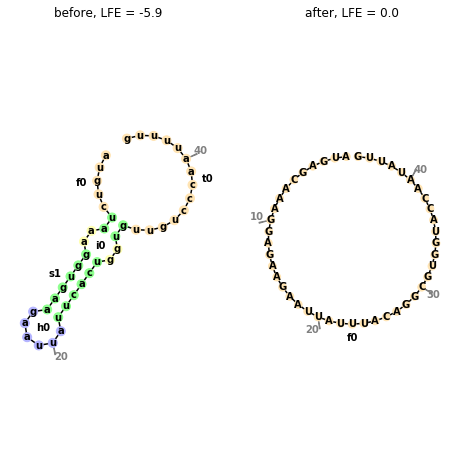

In [34]:
output_path = r'report_output_folder'
final_sequence = translation_optimizer(seq,opt_parameter='fraction',
                                                    res_enzyme_name="BstX2I_site",
                                                    window_size_GC=30,
                                                    output_path = output_path,
                                                   linker_indices=(70,90))
# final_sequence = translation_optimizer(seq,opt_parameter='TDR',res_enzyme_name="BstX2I_site",window_size_GC=30)
# again